## 0. Import libraries

In [372]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## 1. Load Data

In [373]:
df = pd.read_csv('./total.csv')
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5336,2024-05-14,5246.680176,1363.790039,2353.399902,2730.340088,2753.000000
5337,2024-05-15,5308.149902,1362.550049,2388.699951,2730.340088,2753.000000
5338,2024-05-16,5297.100098,1353.599976,2380.000000,2753.000000,2724.620117
5339,2024-05-17,5303.270020,1346.040039,2412.199951,2724.620117,2742.139893
5340,2024-05-20,5303.270020,1357.339966,2440.800049,2742.139893,2742.139893


In [374]:
col_names = df.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [375]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [376]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.058963e+03,1120.344423,1211.677922,1907.779497,1908.009069
var,1.038342e+06,11160.115926,197225.387372,285104.726788,285077.393331
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [377]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5336,1.109252,0.696796,1.180056,0.777667,0.786430
5337,1.124171,0.694985,1.201109,0.777667,0.786430
5338,1.121489,0.681914,1.195921,0.786430,0.775454
5339,1.122987,0.670873,1.215125,0.775454,0.782230
5340,1.122987,0.687376,1.232182,0.782230,0.782230


In [378]:
class StockDataset(Dataset):
    def __init__(self, y, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[:,i] = y[end_x: end_x + output_window]
        # print(X.shape, Y.shape)
        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

### 3. create dataloader

In [379]:
train_dataset = StockDataset(train_data['kospi'], 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['kospi'], 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(next(iter(test_dataset)))

(5073,) 4945 4945 0 5073
(4945, 128, 1) (4945, 1, 1)
(268,) 140 140 0 268
(140, 128, 1) (140, 1, 1)
78 4945 (128, 1) (1, 1)


## 4. Make a Transformer model

In this sections, we will implement the building blocks of the transformer: [Positional encoding](#1a), [Multi-head attention](#1b) and [Position wise feedforward network](#1c)

In [380]:
4938/64

77.15625

### a. Sinusoidal Positional Encoding
<a id='1a'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [381]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model , max_len, device):
        """
        d_model: dimension of model
        max_len: maximum sequence length
        device: 'cuda' or 'cpu'
        """
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.required_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # [a, b, ...] -> [[a], [b], [c], ...]

        _2i = torch.arange(0, d_model, step=2, device=device) # i is d_model and step=2 means 2*i
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
    
    def forward(self, x):
        # x: Tensor, shape ``[batch_size, seq_len, embedding_dim]
        # d_model = 512
        # print(x.size())
        batch_size, seq_len = x.size()[:2]
        pe = self.encoding[:seq_len, :]
        return pe

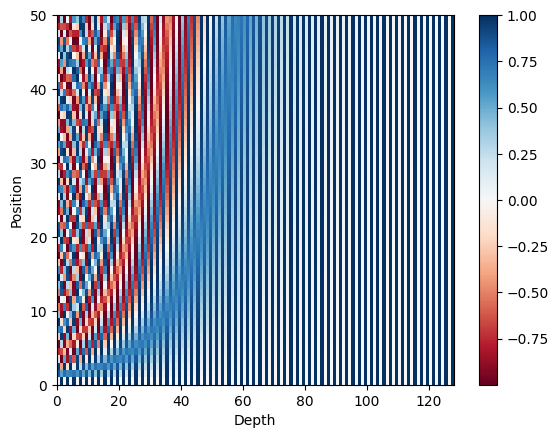

In [382]:
sample_pos_encoding = PositionalEncoding(128, 50, device='cpu')

plt.pcolormesh(sample_pos_encoding.encoding.numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


### b. Scaled dot product attention

__Scaled dot product:__
![picture](./assets/transformer_2.png)

In [383]:
class ScaleDotProductAttention(nn.Module):
    """
    Query: given setence
    Key: same with query(encoder)
    Value: same with key
    """

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # input: 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        # print(q.size(), k_t.size())
        score = (q @ k_t) / math.sqrt(d_tensor)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

### c. MultiheadAttention
<a id='1b'></a>
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [384]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. scale dot product
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out
    
    def split(self, tensor):
        '''
        split tensor by heads
        tensor: [batch_size, seq_len, d_model]
        return: [batch_size, head, seq_len, d_tensor] --- d_model = head * d_tensor
        '''
        batch_size, seq_len, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        # split by # of heads
        return tensor
    
    def concat(self, tensor):
        '''
        inverse of split(tensor)
        tensor: [batch_size, head, seq_len, d_tensor]
        return: [batch_size, seq_len, d_model]
        '''
        batch_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor
        

### d. Position-wise feed forward network
<a id='1c'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [385]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### e. Layer Normalization

In [386]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        # -1 to get mean and var for the last dimension(d_model)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## 5. Embedding input data

make 1 input dimension data to d_model dimentions

In [387]:
class LinearEmbedding(nn.Module):
    def __init__(self, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(1, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        # self.normal = LayerNorm(d_model=d_model)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 1]
        output: [batch_size, seq_len, d_model]
        '''
        residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # x = self.normal(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x


In [388]:
class TrnasformerEmbedding(nn.Module):
    '''
    d_model: dimension of input data
    seq_len: max length of sequence
    '''
    def __init__(self, dropout, d_model, seq_len, device):
        super().__init__()
        self.lin_emb = LinearEmbedding(dropout, d_model)
        self.pos_emb = PositionalEncoding(d_model, seq_len, device)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        lin_emb = self.lin_emb(x)
        pos_emb = self.pos_emb(x)
        return self.dropout(lin_emb + pos_emb)

## 6. Encoder Layer
Trnasformer Encoder Except Embedding

In [389]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.normal1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, dropout=dropout)
        self.normal2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=dropout)
    
    def forward(self, x, src_mask=None):
        # 1. multihead Attention
        residual = x
        x = self.attention(x, x, x)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.normal1(x + residual)

        # 3. positionwise FFN
        residual = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.normal2(x + residual)

        return x

## 7. Encoder
Build Embedding and Encoder Block

In [390]:
class Encoder(nn.Module):
    def __init__(self, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.emb = TrnasformerEmbedding(dropout, d_model, seq_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, ffn_hidden, n_head, dropout)
                                     for _ in range(n_layers)])
    
    def forward(self, x):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x)
        
        return x

## 8. Transformer Encoder
Only use encoder module and FFN 

In [391]:
class TransformerEncoder(nn.Module):
    def __init__(self, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.encoder = Encoder(seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        self.flatten = nn.Flatten()
        self.flatten_dim = seq_len * d_model
        self.linear1 = nn.Linear(self.flatten_dim, self.flatten_dim // 100)
        self.linear2 = nn.Linear(self.flatten_dim // 100, self.flatten_dim // 10000)
        self.linear3 = nn.Linear(self.flatten_dim // 10000, 1)
        # self.linear1 = nn.Linear(self.flatten_dim, self.flatten_dim // 10)
        # self.linear2 = nn.Linear(self.flatten_dim // 10, self.flatten_dim//100)
        # self.linear3 = nn.Linear(self.flatten_dim//100, 1)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x = self.encoder(x)[:, -1, :]
        x = self.encoder(x)
        x = self.flatten(x)
        # print(x.size())
        # x = self.linear1(x)[:, -1, :]
        x = self.linear1(x)
        # print(x.size())
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

## 9. model, loss_fn, optimizer


In [392]:
# next(iter(train_dataloader)).shape
# torch.cuda.empty.cache()
batch_size, seq_len, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 256
dropout = 0.2
ffn_hidden = model_d // 2
n_layers = 8
n_head = 4
lr_sched = True

64 128 1


In [393]:
model = TransformerEncoder(seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 2e-4)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [394]:
model

TransformerEncoder(
  (encoder): Encoder(
    (emb): TrnasformerEmbedding(
      (lin_emb): LinearEmbedding(
        (linear1): Linear(in_features=1, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=256, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (pos_emb): PositionalEncoding()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (layers): ModuleList(
      (0-7): 8 x EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=256, out_features=256, bias=True)
          (w_k): Linear(in_features=256, out_features=256, bias=True)
          (w_v): Linear(in_features=256, out_features=256, bias=True)
          (w_concat): Linear(in_features=256, out_features=256, bias=True)
        )
        (normal1): LayerNorm()
        (dropout1): Dropout(p=0.2, inplace=False)
    

## 10. Train and Test function

In [395]:
linear_model = LinearEmbedding(0.2, model_d).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = linear_model(in_x)
out.size()

torch.Size([64, 128, 256])

In [396]:
emb_model = TrnasformerEmbedding(0.2, model_d, seq_len, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = emb_model(in_x)
out.size()

torch.Size([64, 128, 256])

In [397]:
encoder_model = Encoder(seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = encoder_model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 128, 256])
torch.Size([64, 1, 1])
torch.Size([64])


In [398]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64])


In [399]:
epochs = 1000
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output.float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 8))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 19.449027, lr:  0.0002
epochs: 1, loss: 1.507450, lr:  0.0002
epochs: 2, loss: 1.166718, lr:  0.0002
epochs: 3, loss: 1.006931, lr:  0.0002
epochs: 4, loss: 0.873843, lr:  0.0002
epochs: 5, loss: 0.769675, lr:  0.0002
epochs: 6, loss: 0.694123, lr:  0.0002
epochs: 7, loss: 0.740939, lr:  0.0002
epochs: 8, loss: 0.647646, lr:  0.0002
epochs: 9, loss: 0.647309, lr:  0.0002
epochs: 10, loss: 0.610181, lr:  0.0002
epochs: 11, loss: 0.662869, lr:  0.0002
epochs: 12, loss: 0.583994, lr:  0.0002
epochs: 13, loss: 0.634853, lr:  0.0002
epochs: 14, loss: 0.623334, lr:  0.0002
epochs: 15, loss: 0.537512, lr:  0.0002
epochs: 16, loss: 0.499089, lr:  0.0002
epochs: 17, loss: 0.578444, lr:  0.0002
epochs: 18, loss: 0.567095, lr:  0.0002
epochs: 19, loss: 0.554820, lr:  0.0002
epochs: 20, loss: 0.482337, lr:  0.0002
epochs: 21, loss: 0.503509, lr:  0.0002
epochs: 22, loss: 0.520262, lr:  0.0002
epochs: 23, loss: 0.454091, lr:  0.0002
epochs: 24, loss: 0.460047, lr:  0.0002
epochs: 2

In [400]:
save_path = 'transormer_kospi_only_window_flatten_modeld' + str(model_d) + '_seqlen' + str(seq_len) + '_layaers' + str(n_layers) + '_nhead' + str(n_head) + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
print(save_path)
df_loss

transormer_kospi_only_window_flatten_modeld256_seqlen128_layaers8_nhead4.pt


,epoch,loss
0,0.0,19.449027
1,1.0,1.507450
2,2.0,1.166718
3,3.0,1.006931
4,4.0,0.873843
...,...,...
995,995.0,0.083701
996,996.0,0.084477
997,997.0,0.084650
998,998.0,0.100165


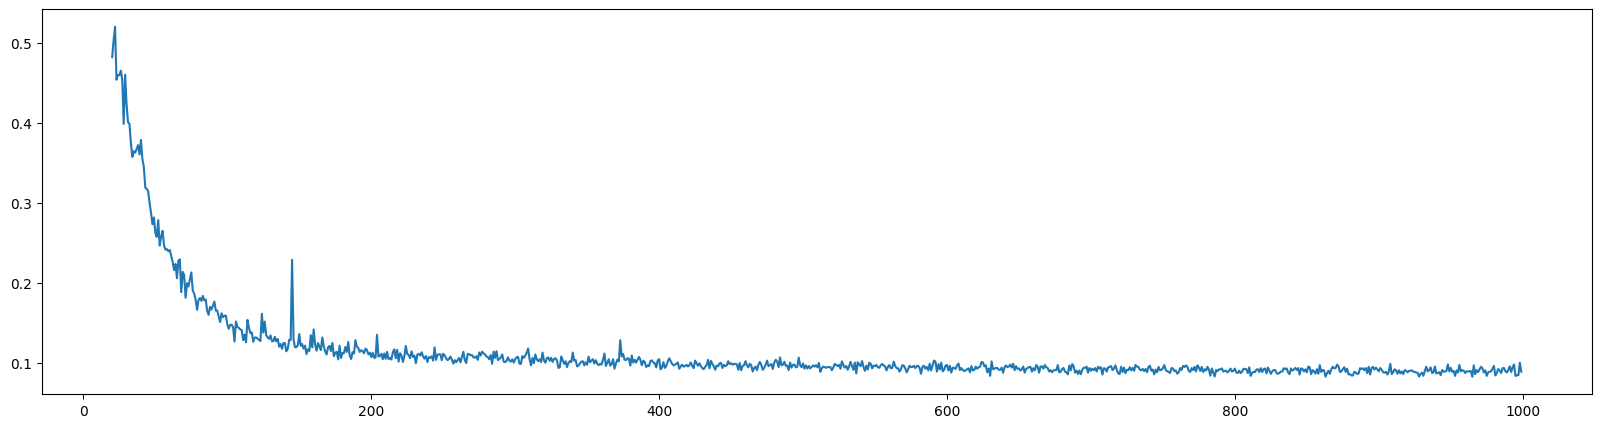

In [401]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [402]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0][0]]
            num += 1

In [403]:
test_result

,pred,pred_rescale,real
0,0.648694,2396.867034,2443.959961
1,0.628319,2344.183915,2421.620117
2,0.632006,2353.717466,2427.080078
3,0.671171,2454.984093,2409.659912
4,0.716824,2573.025363,2403.760010
...,...,...,...
135,0.727180,2599.801912,2730.340088
136,0.769275,2708.642056,2730.340088
137,0.753635,2668.203986,2753.000000
138,0.758312,2680.297849,2724.620117


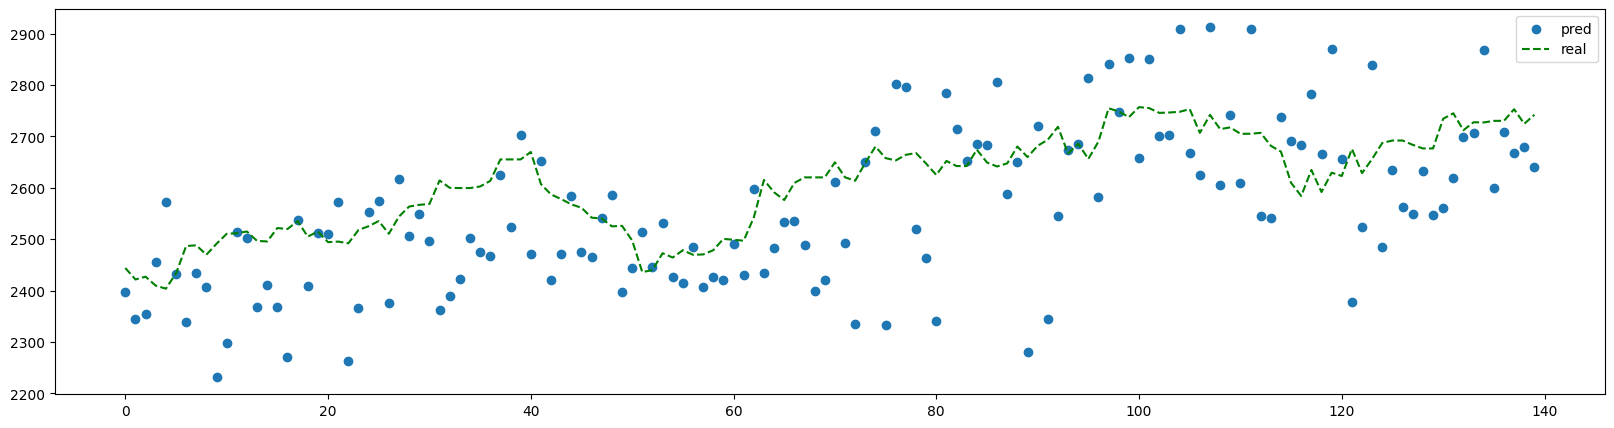

In [404]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

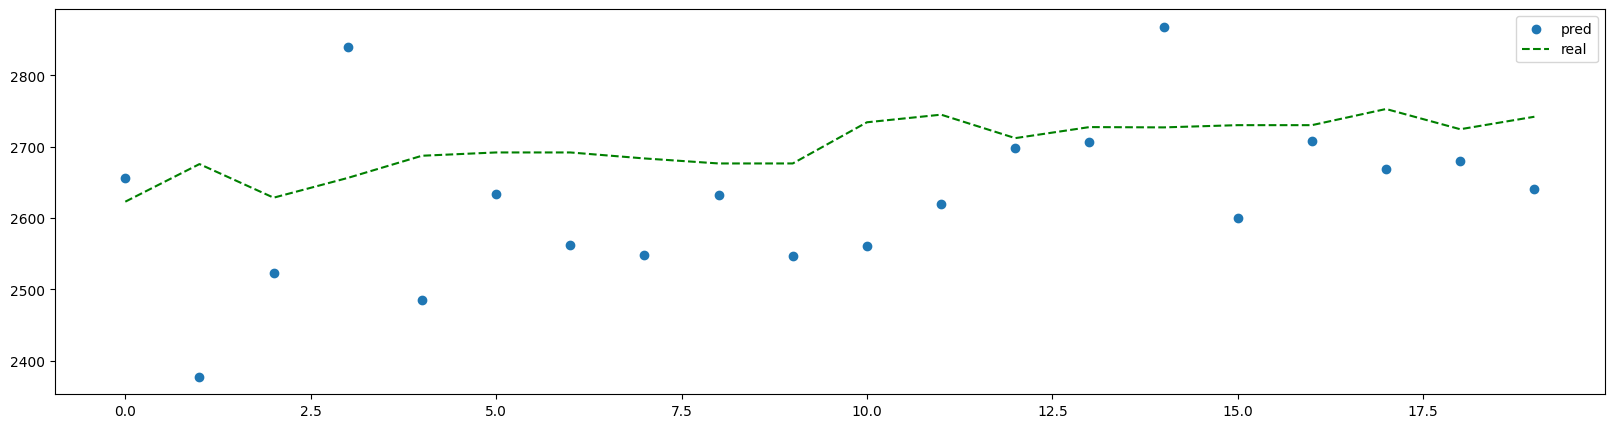

In [405]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

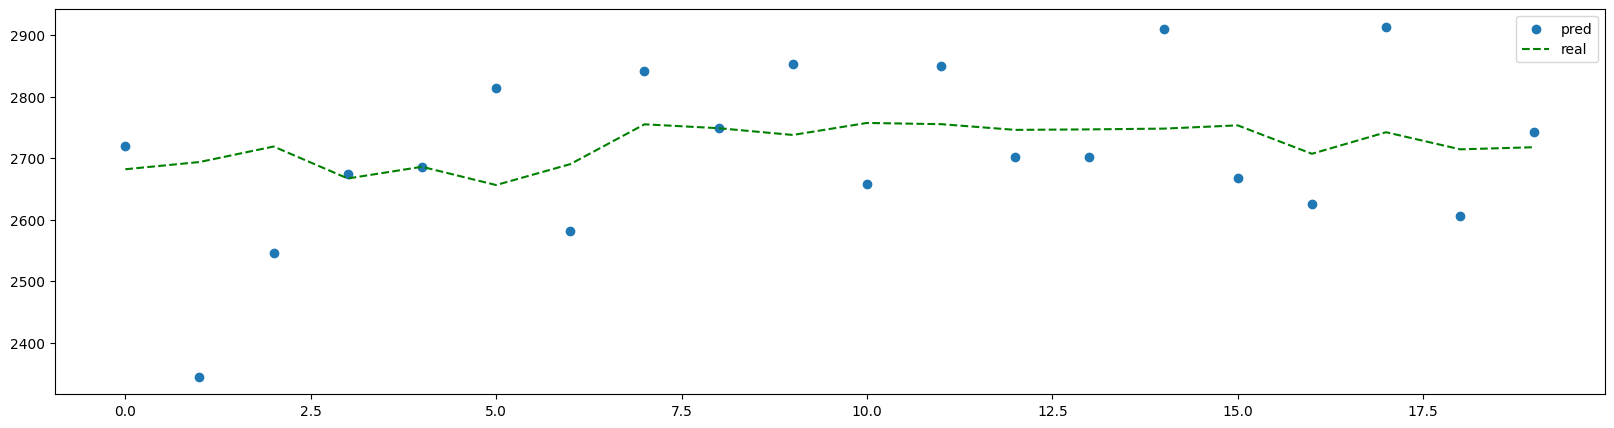

In [406]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

In [407]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.693499,2512.714015,2514.949951,2419.588788,2419.160888,2411.078416,2519.364014,2512.618970,2480.070984,2423.793108,2414.960231,2411.078416,2506.719500,2496.990978,2489.412824
20,0.692775,2510.842443,2494.280029,2448.162349,2440.444287,2418.489088,2513.868018,2511.004980,2482.586987,2438.623698,2425.038705,2418.489088,2504.600188,2496.706022,2489.774370
21,0.716633,2572.529883,2495.379883,2508.677806,2446.229285,2429.634381,2508.981982,2509.372974,2486.274976,2461.353115,2440.324834,2429.634381,2503.035121,2496.568580,2490.179945
22,0.597045,2263.321646,2492.070068,2453.824409,2422.263422,2417.891621,2500.337988,2507.083984,2489.524475,2427.842022,2422.210679,2417.891621,2501.179603,2496.108211,2490.313400
23,0.636437,2365.174834,2517.850098,2444.916564,2421.974750,2414.253114,2502.906006,2509.206006,2494.933984,2417.264434,2416.439700,2414.253114,2503.993414,2498.308090,2492.213980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.727180,2599.801912,2730.340088,2698.399977,2634.273821,2650.122124,2728.473975,2710.569971,2675.454993,2659.442646,2653.522517,2650.122124,2709.534367,2696.752372,2685.104330
136,0.769275,2708.642056,2730.340088,2716.186137,2648.925900,2652.912276,2725.531982,2714.397974,2682.763000,2667.642548,2658.533395,2652.912276,2713.001988,2699.805807,2687.261110
137,0.753635,2668.203986,2753.000000,2710.197692,2660.873478,2653.641321,2733.704004,2721.332983,2688.678003,2667.736121,2659.412541,2653.641321,2719.668323,2704.641652,2690.395266
138,0.758312,2680.297849,2724.620117,2705.050345,2665.627677,2654.912121,2733.102051,2726.132007,2695.316003,2669.829742,2661.311209,2654.912121,2720.493622,2706.457879,2692.026871


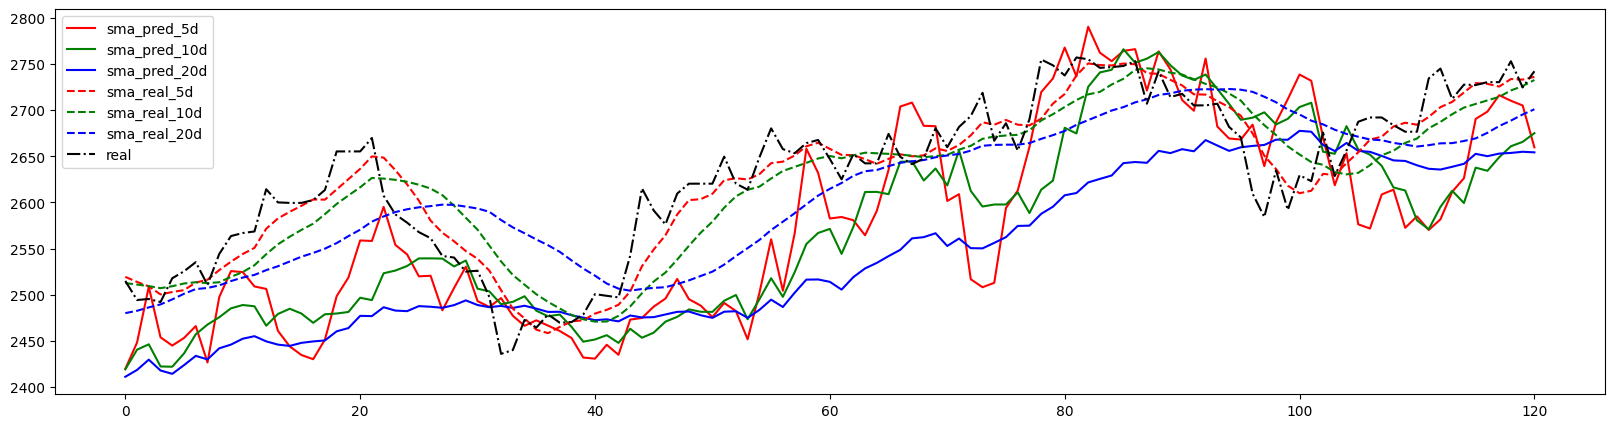

In [408]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

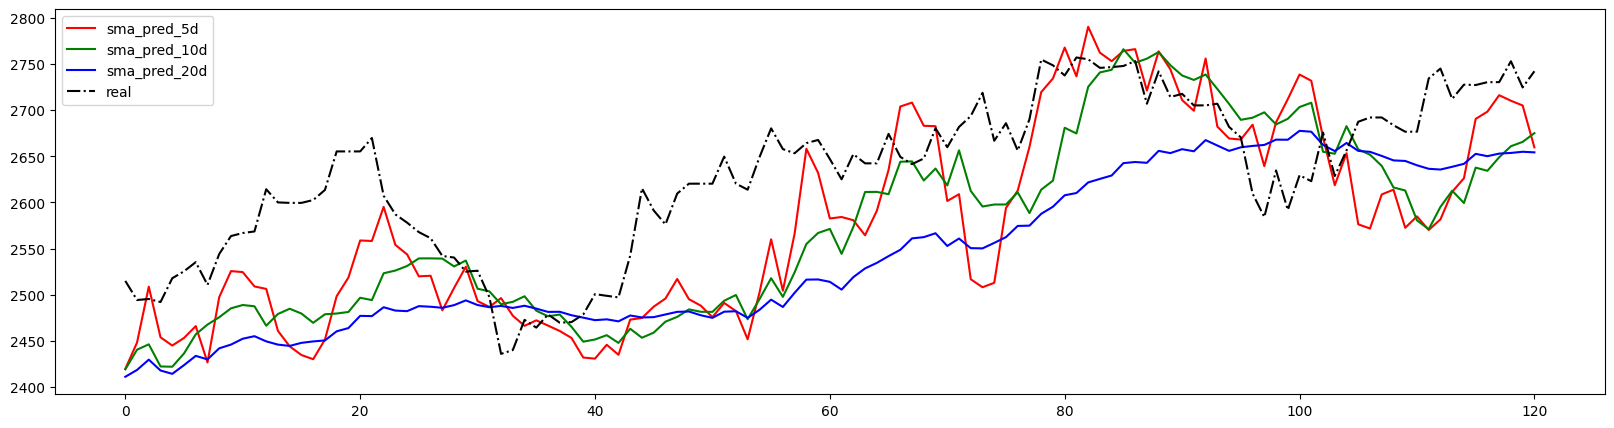

In [409]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

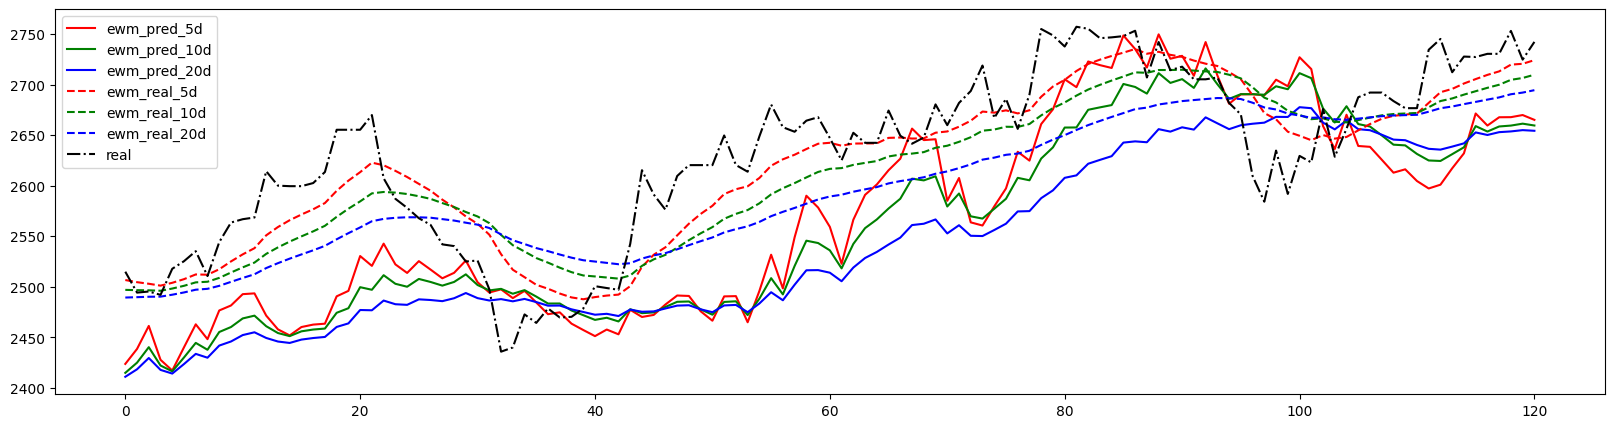

In [410]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## 11. evaluation metrics
MAPE, MSE

In [411]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 16933.9387, MAPE: 0.0396
